In [1]:
#mounting google drive
from google.colab import drive
drive.mount('/content/gdrive')
path = "/content/gdrive/My Drive/Colab Notebooks/experiments/object_detection"
work_dir = "/content"
import sys
if not path in sys.path: sys.path.append(path)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
import torch, torchvision, os, requests, random
import torch.nn as nn
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from io import BytesIO
from PIL import Image
from collections import OrderedDict
#from tqdm import tqdm.notebook.tqdm as tqdm
from tqdm.notebook import tqdm

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# Memory profiler: Using : %%memit or %mprun -f {imported function} {imported function}(args)
# https://pypi.org/project/memory-profiler/
!pip install memory_profiler
%load_ext memory_profiler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

  Created wheel for memory-profiler: filename=memory_profiler-0.57.0-cp36-none-any.whl size=28992 sha256=4517750e51205ea5ed18755fd6e8c3e8a38863a6ad3c7b23a19e16fb6978fd33
  Stored in directory: /root/.cache/pip/wheels/74/20/b5/20964ef97be73d2c3a695c9cad7bccd96d1e3e737a8163861f
Successfully built memory-profiler
cpu


In [8]:
#@title Some functions for COCO, display_instances, model_size etc. Just run this cell.

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches,  lines
from matplotlib.patches import Polygon
from skimage.measure import find_contours
import colorsys, random, sys
from itertools import chain
from reprlib import repr
from functools import partial
from types import ModuleType, FunctionType

def size_of_model(model):
    torch.save(model.state_dict(), "/tmp/temp.p")
    out = os.path.getsize("/tmp/temp.p")
    os.remove('/tmp/temp.p')
    return out

def object_size(o, handlers={}, verbose=False, seen=None):
    """ Returns the approximate memory footprint an object and all of its contents.

    Automatically finds the contents of the following builtin containers and
    their subclasses:  tuple, list, deque, dict, set and frozenset.
    To search other containers, add handlers to iterate over their contents:

        handlers = {SomeContainerClass: iter,
                    OtherContainerClass: OtherContainerClass.get_elements}

    """

    # Custom objects know their class.
    # Function objects seem to know way too much, including modules.
    # Exclude modules as well.
    BLACKLIST = type, ModuleType, FunctionType

    dict_handler = lambda d: chain.from_iterable(d.items())
    all_handlers = {tuple: iter,
                    list: iter,                    
                    dict: dict_handler,
                    set: iter,
                    frozenset: iter,
                   }
    all_handlers.update(handlers)     # user handlers take precedence
    if seen is None: seen = set()     # track which object id's have already been seen
    default_size = sys.getsizeof(0)       # estimate sizeof object without __sizeof__

    def sizeof(o, level=0):
        if isinstance(o, BLACKLIST):
            print('sizeof() does not take argument of type: '+ str(type(obj)))

        if id(o) in seen:       # do not double count the same object
            return 0

        seen.add(id(o))
        n = repr(o)
        if torch.is_tensor(o) or (hasattr(o, 'data') and torch.is_tensor(o.data)):
            s = sys.getsizeof(o.storage(), default_size)   
            n = 'Shape: ' + str(tuple(o.size())) if torch.is_tensor(o) else str(tuple(o.data.size()))
        elif (hasattr(o, 'saved_tensors') and torch.is_tensor(o.saved_tensors)):
            n = 'Saved_T_shape:  ' + str(tuple(o.saved_tensors.size()))
        elif isinstance(o, (np.ndarray, np.generic)):
            s = o.nbytes
            n = 'Shape: ' + str(o.shape)        
        else:    
            s = sys.getsizeof(o, default_size)

        if verbose:            
            print('{} {:<10} \t {:>10} bytes;  {}'.format(' ' * 2 * level, str(type(o)).split('\'')[-2].split('.')[-1], s, n), file=sys.stderr)

        for typ, handler in all_handlers.items():
            if isinstance(o, typ):
                s += sum(map(partial(sizeof, level=level+1), handler(o)))
                break
        return s
    
    return sizeof(o)
  
def model_summarize(model, level=0,
                    verbose=False, 
                    show_weights=True, 
                    show_parameters=True,
                    show_sizes=True):
    """Summarizes torch model by showing trainable parameters and weights."""

    def module_summarize(module, name='', sum_of_params=0, sum_of_sizes=0, level=level):
        
        # if it contains layers let call it recursively to get params and weights
        if len(module._modules.values()) > 0:
            if verbose:
                print('{}{} {}: '.format('  '*level, name, module.__class__.__name__))
            for key, mod in module._modules.items():
                p,s = module_summarize(mod, name='('+key+')', level=level+1)
                sum_of_params += p
                sum_of_sizes += s      
        else:
            params = sum([np.prod(p.size()) for p in module.parameters()])  
            weights = tuple([tuple(p.size()) for p in module.parameters()])
            size = sum([object_size(p) for p in module.parameters()])        
            sum_of_params += params
            sum_of_sizes += size      
            weight_str = '{:<25}'.format('W: ' + str(weights)) if show_weights else ''
            params_str = '{:<15}'.format('P: ' + str(params)) if show_parameters else ''
            size_str = '{:<12}'.format('S: ' + str(size)) if show_sizes else ''
            if verbose:
                print('{}{:<8} {}{}{} {}'.format('  '*level, name, size_str, params_str, weight_str, module.__repr__()))
        
        return sum_of_params, sum_of_sizes

    return module_summarize(model)  


def random_colors(N, bright=True):
    """
    Generate random colors.
    To get visually distinct colors, generate them in HSV space then
    convert to RGB.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors

def apply_mask(image, mask, color, alpha=0.5):
    """Apply the given mask to the image.
    """
    for c in range(3):
        image[:, :, c] = np.where(mask == 1,
                                  image[:, :, c] *
                                  (1 - alpha) + alpha * color[c],
                                  image[:, :, c])
    return image


def display_instances(image, prediction, class_names=None,
                      scores=None, title="",
                      figsize=(10, 10), ax=None,
                      show_mask=True, show_bbox=True,
                      colors=None, captions=None, N=12, tresh=0.5):
    """
    prediction: Dict:
    	boxes: [num_instances, (y1, x1, y2, x2)] in image coordinates.
    	masks: [num_instances, height, width]
    	labels: [num_instances]
    class_names: list of class names of the dataset
    scores: (optional) confidence scores for each box
    title: (optional) Figure title
    show_mask, show_bbox: To show masks and bounding boxes or not
    figsize: (optional) the size of the image
    colors: (optional) An array or colors to use with each object
    captions: (optional) A list of strings to use as captions for each object
    N: number of boxes to show
    """

    if class_names is None:
        class_names = ['background', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant',
    'street sign', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra',
    'giraffe', 'hat', 'backpack', 'umbrella', 'shoe', 'eye glasses', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard',
    'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'plate',
    'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli',
    'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'mirror', 'dining table',
    'window', 'desk', 'toilet', 'door', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave',
    'oven', 'toaster', 'sink', 'refrigerator', 'blender', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush',
    'hair brush',]

    # converting predicted data and image    
    if not isinstance(prediction, (dict)):      
        boxes = prediction.detach().cpu().numpy()
        labels = None
        masks = None
        scores = None
    else:  # prediction is prediction not targets not boxes itself
        scores = prediction.get('scores', None)
        if scores is not None:
            if N > (scores > tresh).sum(): N = (scores > tresh).sum()        
        boxes = prediction['boxes'][:N].detach().cpu().numpy()
        masks = prediction.get('masks', None)
        if masks is not None: 
            masks = (masks.squeeze()[:N].detach().cpu().numpy() > 0.5)
        labels = prediction['labels'][:N].detach().cpu().numpy().astype(np.uint8)
    if type(image) is torch.Tensor:
        image = np.array(torchvision.transforms.ToPILImage()(image))
    # Number of instances
    N = boxes.shape[0]
    #if not N:
    #    print("\n*** No instances to display *** \n")
    #else:
    #    assert boxes.shape[0] == labels.shape[0]

    # If no axis is passed, create one and automatically call show()
    auto_show = False
    if not ax:
        _, ax = plt.subplots(1, figsize=figsize)
        auto_show = True

    # Generate random colors
    colors = colors or random_colors(N)

    # Show area outside image boundaries.
    height, width = image.shape[:2]
    ax.set_ylim(height + 10, -10)
    ax.set_xlim(-10, width + 10)
    ax.axis('off')
    ax.set_title(title)

    masked_image = image.copy()
    for i in range(N):
        color = colors[i]

        # Bounding box
        if not np.any(boxes[i]):
            # Skip this instance. Has no bbox. Likely lost in image cropping.
            continue
        x1, y1, x2, y2 = boxes[i]
        if show_bbox:
            p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2,
                                alpha=0.7, linestyle="dashed",
                                edgecolor=color, facecolor='none')
            ax.add_patch(p)

        # Label
        if labels is not None:
            if not captions:
                class_id = labels[i]
                score = scores[i] if scores is not None else None
                label = class_names[class_id]
                caption = "{} {:.3f}".format(label, score) if score else label
            else:
                caption = captions[i]
            ax.text(x1, y1 + 8, caption,
                    color='w', size=11, backgroundcolor="none")

        # Mask
        if masks is not None:
            mask = masks[i]
            if show_mask:
                masked_image = apply_mask(masked_image, mask, color)        
            ax.imshow(masked_image)

            # Mask Polygon
            # Pad to ensure proper polygons for masks that touch image edges.
            padded_mask = np.zeros(
                (mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)

            padded_mask[1:-1, 1:-1] = mask
            contours = find_contours(padded_mask, 0.5)
            for verts in contours:
                # Subtract the padding and flip (y, x) to (x, y)
                verts = np.fliplr(verts) - 1
                p = Polygon(verts, facecolor="none", edgecolor=color)
                ax.add_patch(p)
        else:
            ax.imshow(image)

    if auto_show:
        plt.show()


# transforms
import random
import math
from torch import nn, Tensor

# https://github.com/pytorch/vision/blob/master/references/detection/transforms.py

def _flip_coco_person_keypoints(kps, width):
    flip_inds = [0, 2, 1, 4, 3, 6, 5, 8, 7, 10, 9, 12, 11, 14, 13, 16, 15]
    flipped_data = kps[:, flip_inds]
    flipped_data[..., 0] = width - flipped_data[..., 0]
    # Maintain COCO convention that if visibility == 0, then x, y = 0
    inds = flipped_data[..., 2] == 0
    flipped_data[inds] = 0
    return flipped_data


class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target


class RandomHorizontalFlip(object):
    def __init__(self, prob):
        self.prob = prob

    def __call__(self, image, target):
        if random.random() < self.prob:
            height, width = image.shape[-2:]
            image = image.flip(-1)
            bbox = target["boxes"]
            bbox[:, [0, 2]] = width - bbox[:, [2, 0]]
            target["boxes"] = bbox
            if "masks" in target:
                target["masks"] = target["masks"].flip(-1)
            if "keypoints" in target:
                keypoints = target["keypoints"]
                keypoints = _flip_coco_person_keypoints(keypoints, width)
                target["keypoints"] = keypoints
        return image, target


class ToTensor(object):
    def __call__(self, image, target):
        image = torchvision.transforms.functional.to_tensor(image)
        return image, target


# COCO utils

import os, copy
import torch.utils.data

from pycocotools import mask as coco_mask
from pycocotools.coco import COCO

# https://github.com/pytorch/vision/blob/master/references/detection/coco_utils.py

def convert_coco_poly_to_mask(segmentations, height, width):
    masks = []
    for polygons in segmentations:
        rles = coco_mask.frPyObjects(polygons, height, width)
        mask = coco_mask.decode(rles)
        if len(mask.shape) < 3:
            mask = mask[..., None]
        mask = torch.as_tensor(mask, dtype=torch.uint8)
        mask = mask.any(dim=2)
        masks.append(mask)
    if masks:
        masks = torch.stack(masks, dim=0)
    else:
        masks = torch.zeros((0, height, width), dtype=torch.uint8)
    return masks


class ConvertCocoPolysToMask(object):
    def __call__(self, image, target):
        w, h = image.size

        image_id = target["image_id"]
        image_id = torch.tensor([image_id])

        anno = target["annotations"]

        anno = [obj for obj in anno if obj['iscrowd'] == 0]

        boxes = [obj["bbox"] for obj in anno]
        # guard against no boxes via resizing
        boxes = torch.as_tensor(boxes, dtype=torch.float32).reshape(-1, 4)
        boxes[:, 2:] += boxes[:, :2]
        boxes[:, 0::2].clamp_(min=0, max=w)
        boxes[:, 1::2].clamp_(min=0, max=h)

        classes = [obj["category_id"] for obj in anno]
        classes = torch.tensor(classes, dtype=torch.int64)

        segmentations = [obj["segmentation"] for obj in anno]
        masks = convert_coco_poly_to_mask(segmentations, h, w)

        keypoints = None
        if anno and "keypoints" in anno[0]:
            keypoints = [obj["keypoints"] for obj in anno]
            keypoints = torch.as_tensor(keypoints, dtype=torch.float32)
            num_keypoints = keypoints.shape[0]
            if num_keypoints:
                keypoints = keypoints.view(num_keypoints, -1, 3)

        keep = (boxes[:, 3] > boxes[:, 1]) & (boxes[:, 2] > boxes[:, 0])
        boxes = boxes[keep]
        classes = classes[keep]
        masks = masks[keep]
        if keypoints is not None:
            keypoints = keypoints[keep]

        target = {}
        target["boxes"] = boxes
        target["labels"] = classes
        target["masks"] = masks
        target["image_id"] = image_id
        if keypoints is not None:
            target["keypoints"] = keypoints

        # for conversion to coco api
        area = torch.tensor([obj["area"] for obj in anno])
        iscrowd = torch.tensor([obj["iscrowd"] for obj in anno])
        target["area"] = area
        target["iscrowd"] = iscrowd

        return image, target

def _coco_remove_images_without_annotations(dataset, cat_list=None):
    def _has_only_empty_bbox(anno):
        return all(any(o <= 1 for o in obj["bbox"][2:]) for obj in anno)

    def _count_visible_keypoints(anno):
        return sum(sum(1 for v in ann["keypoints"][2::3] if v > 0) for ann in anno)

    min_keypoints_per_image = 10

    def _has_valid_annotation(anno):
        # if it's empty, there is no annotation
        if len(anno) == 0:
            return False
        # if all boxes have close to zero area, there is no annotation
        if _has_only_empty_bbox(anno):
            return False
        # keypoints task have a slight different critera for considering
        # if an annotation is valid
        if "keypoints" not in anno[0]:
            return True
        # for keypoint detection tasks, only consider valid images those
        # containing at least min_keypoints_per_image
        if _count_visible_keypoints(anno) >= min_keypoints_per_image:
            return True
        return False

    assert isinstance(dataset, torchvision.datasets.CocoDetection)
    ids = []
    for ds_idx, img_id in enumerate(dataset.ids):
        ann_ids = dataset.coco.getAnnIds(imgIds=img_id, iscrowd=None)
        anno = dataset.coco.loadAnns(ann_ids)
        if cat_list:
            anno = [obj for obj in anno if obj["category_id"] in cat_list]
        if _has_valid_annotation(anno):
            ids.append(ds_idx)

    dataset = torch.utils.data.Subset(dataset, ids)
    return dataset

class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, ann_file, transforms):
        super(CocoDetection, self).__init__(img_folder, ann_file)
        self._transforms = transforms

    def __getitem__(self, idx):
        img, target = super(CocoDetection, self).__getitem__(idx)
        image_id = self.ids[idx]
        target = dict(image_id=image_id, annotations=target)        
        if self._transforms is not None:
            img, target = self._transforms(img, target)
        return img, target


def get_coco(root, image_set='val', transforms=Compose([ToTensor()]), mode='instances', limit=False):
    anno_file_template = "{}_{}2017.json"
    PATHS = {
        "train": ("train2017", os.path.join("annotations", anno_file_template.format(mode, "train"))),
        "val": ("val2017", os.path.join("annotations", anno_file_template.format(mode, "val"))),
        #"train": ("val2017", os.path.join("annotations", anno_file_template.format(mode, "val")))
    }

    t = [ConvertCocoPolysToMask()]

    if transforms is not None:
        t.append(transforms)
    transforms = Compose(t)

    img_folder, ann_file = PATHS[image_set]
    img_folder = os.path.join(root, img_folder) # /content/data/val2017
    ann_file = os.path.join(root, ann_file) # /content/data/annotations/instances_val2017.json

    dataset = CocoDetection(img_folder, ann_file, transforms=transforms)

    if image_set == "train":
        dataset = _coco_remove_images_without_annotations(dataset)

    if limit:
      dataset = torch.utils.data.Subset(dataset, [i for i in range(500)])

    return dataset

print('Functions has been imported!')

Functions has been imported!


#COCO Dataset val2017

In [0]:
#Downloading COCO annotations into google drive if needed
!if [ ! -e "$path/annotations_trainval2017.zip" ]; then wget -P "$path" "http://images.cocodataset.org/annotations/annotations_trainval2017.zip"; fi
#Creating data subdirectory in /content
!if [ ! -e "$work_dir/data" ]; then echo "$work_dir/data is not found. Creating..."; mkdir "$work_dir/data"; fi

#Copying annotations file from google drive and unzip
!cp -u "$path/annotations_trainval2017.zip" "$work_dir/data"
!unzip -qo "$work_dir/data/annotations_trainval2017.zip" -d "$work_dir/data"
!rm "$work_dir/data/annotations_trainval2017.zip"

#Downloading COCO val2017 Dataset if needed
%cd "$work_dir"
#!if [ ! -e "$work_dir/data/val2017" ]; then echo "$work_dir/data/val2017 is not found. Creating directory & Downloading dataset"; mkdir -p "$work_dir/data/val2017"; gsutil -m rsync gs://images.cocodataset.org/val2017 "$work_dir/data/val2017"; fi
!if [ ! -e "$work_dir/data/val2017.zip" ]; then wget -P "$work_dir/data" "http://images.cocodataset.org/zips/val2017.zip"; fi
!if [ ! -e "$work_dir/data/val2017" ]; then echo "$work_dir/data/val2017 is not found. Creating directory & Unziping dataset"; mkdir -p "$work_dir/data/val2017"; unzip -qo "$work_dir/data/val2017.zip" -d "$work_dir/data"; fi
!rm "$work_dir/data/val2017.zip"




/content/data is not found. Creating...
/content
--2020-04-12 19:29:49--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.37.100
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.37.100|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘/content/data/val2017.zip’

val2017.zip         100%[===================>] 777.80M  35.3MB/s    in 23s     

2020-04-12 19:30:12 (34.2 MB/s) - ‘/content/data/val2017.zip’ saved [815585330/815585330]

/content/data/val2017 is not found. Creating directory & Unziping dataset


loading annotations into memory...
Done (t=0.80s)
creating index...
index created!
loading annotations into memory...
Done (t=0.45s)
creating index...
index created!


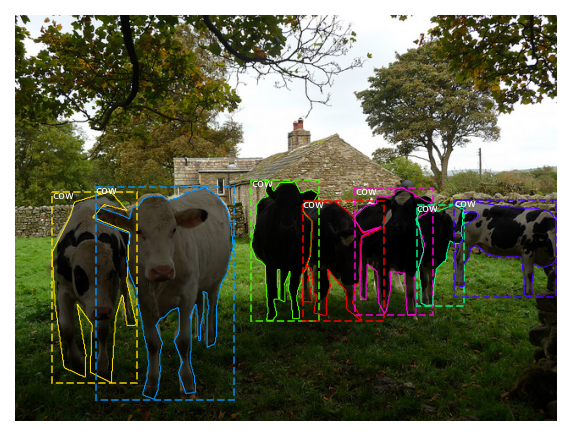

torch.Size([3, 480, 640])


In [0]:
def collate_fn(batch):
    return tuple(zip(*batch))    

import json
ann_path = os.path.join(work_dir, 'data/annotations/instances_val2017.json')
with open(ann_path) as json_file:
    annot_dict = json.load(json_file)

# extract indices files with 640x480 resolution only
images_640x480=[]
for i in annot_dict['images']:
    if (i['height'] == 480) and (i['width'] == 640):
        images_640x480.append(i['id'])
image_sample = random.choices(images_640x480, k=3)

from pycocotools.coco import COCO
coco = COCO(ann_path)
ids = list(sorted(coco.imgs.keys()))
dataset = get_coco(os.path.join(work_dir, 'data'), image_set='val', 
                   transforms=Compose([ToTensor()]), 
                   mode='instances', limit=False)
im, tar = dataset.__getitem__(ids.index(image_sample[0]))
train_sampler = torch.utils.data.RandomSampler(dataset)
test_sampler = torch.utils.data.SequentialSampler(dataset)
train_batch_sampler = torch.utils.data.BatchSampler(
            train_sampler, batch_size=2, drop_last=True)

data_loader = torch.utils.data.DataLoader(
        dataset, batch_sampler=train_batch_sampler, num_workers=1,
        collate_fn=collate_fn)

data_loader_test = torch.utils.data.DataLoader(
        dataset, batch_size=1,
        sampler=test_sampler, num_workers=1,
        collate_fn=collate_fn)

display_instances(im, tar)
print(im.size())

#Some usefull functions

In [0]:
def compare_tensors(a, b):
    if torch.all(a == b).item():
        print('Absolutelly the same!')
    else:
        print('Tensors differs!!!')

def print_size_of_model(model):
    torch.save(model.state_dict(), "temp.p")
    print('Size (MB):', os.path.getsize("temp.p")/1e6)
    os.remove('temp.p')    

def get_image(url='https://www.sb.by/upload/iblock/e26/e2695b04032819905a3150f90ef27dd9.jpg'):
    return torchvision.transforms.ToTensor()(
        Image.open(BytesIO(requests.get(url).content)))

#Quantized ResNet50-Backbone and Box_Head 

###Convert functions

In [6]:
print(torch.backends.quantized.supported_engines)

def calibrate(model, data_loader, num=5, device='cpu'):
    model.to(device)
    model.eval()
    cnt = 0
    with torch.no_grad():
        for image, target in data_loader:  
            print([im.shape for im in image])
            image = [im for im in image]
            output = model(image)
            cnt += 1
            if cnt >= num:
                return

def _replace_relu(module):
    reassign = {}
    for name, mod in module.named_children():
        _replace_relu(mod)
        # Checking for explicit type instead of instance
        # as we only want to replace modules of the exact type
        # not inherited classes
        if type(mod) == nn.ReLU or type(mod) == nn.ReLU6:
            reassign[name] = nn.ReLU(inplace=False)

    for key, value in reassign.items():
        module._modules[key] = value

def quantize_module(model, backend, orig_model, dataloader, num=5):    
    if backend not in torch.backends.quantized.supported_engines:
        raise RuntimeError("Quantized backend not supported ")
    _replace_relu(model)    
    torch.backends.quantized.engine = backend
    model.eval()
    model.qconfig = torch.quantization.get_default_qconfig(backend)
    model.fuse_model()
    torch.quantization.prepare(model, inplace=True)    
    calibrate(model, data_loader, orig_model.transform, num=5)
    torch.quantization.convert(model, inplace=True)
    return

def compare_two_models(model1, model2, img_url='https://www.sb.by/upload/iblock/e26/e2695b04032819905a3150f90ef27dd9.jpg'):
    img1 = Image.open(BytesIO(requests.get(img_url).content))
    x = [torchvision.transforms.ToTensor()(img1)]        
    model1.eval()    
    model2.eval()
    with torch.jit.optimized_execution(False), torch.no_grad():
        out1 = model1(x)    
        if type(out1) == tuple: out1 = out1[1]
        out2 = model2(x)
        if type(out2) == tuple: out2 = out2[1]
        display_instances(x[0], out1[0])
        display_instances(x[0], out2[0])       

['qnnpack', 'none', 'fbgemm']


###Model code

In [0]:
from collections import OrderedDict

import torch
import torch.nn.functional as F
from torch import nn, Tensor

from torch.jit.annotations import Tuple, List, Dict

# Here we quntize/dequantize tensors only in BackboneWithFPN class

class IntermediateLayerGetterQuant(torchvision.models._utils.IntermediateLayerGetter):

    def __init__(self, model=torchvision.models.quantization.resnet50(pretrained=False, quantize=False, norm_layer=torch.nn.BatchNorm2d),
                 return_layers={'layer1': '0', 'layer2': '1', 'layer3': '2', 'layer4': '3'}):
        if not set(return_layers).issubset([name for name, _ in model.named_children()]):
            raise ValueError("return_layers are not present in model")
        super(IntermediateLayerGetterQuant, self).__init__(model, return_layers)

    def fuse_model(self):
        torch.quantization.fuse_modules(self, ['conv1', 'bn1', 'relu'], inplace=True)
        for m in self.modules():
            if type(m) == torchvision.models.quantization.resnet.QuantizableBottleneck or \
               type(m) == torchvision.models.quantization.resnet.QuantizableBasicBlock:
                m.fuse_model()        

class FeaturePyramidNetworkQuant(nn.Module):

    __constants__ = ['inner_blocks', 'layer_blocks']

    def __init__(self, in_channels_list, out_channels, extra_blocks=None):
        super(FeaturePyramidNetworkQuant, self).__init__()
        self.inner_blocks = nn.ModuleList()
        self.layer_blocks = nn.ModuleList()
        self.FPN_add = nn.quantized.FloatFunctional()       
        for in_channels in in_channels_list:
            if in_channels == 0:
                continue
            inner_block_module = nn.Conv2d(in_channels, out_channels, 1)
            layer_block_module = nn.Conv2d(out_channels, out_channels, 3, padding=1)
            self.inner_blocks.append(inner_block_module)
            self.layer_blocks.append(layer_block_module)
    
    def forward(self, x:Dict[str, torch.Tensor]):

        # unpack OrderedDict into two lists for easier handling
        names = list(x.keys())
        x = list(x.values())

        in_results = []
        i = 0
        for mod in self.inner_blocks:            
            in_results.append(mod(x[i]))
            i += 1
        l_results = [in_results[-1]]        
        i = len(in_results) - 2
        while i >= 0:
            feat_shape = in_results[i].shape[-2:]
            inner_top_down = torch.nn.functional.interpolate(l_results[0], size=feat_shape, mode="nearest")
            l_results.insert(0, self.FPN_add.add(in_results[i], inner_top_down))
            i -= 1

        i = 0
        results = []
        for mod in self.layer_blocks:
            results.append(mod(l_results[i]))
            i += 1

        # make it back an OrderedDict
        out = OrderedDict([(k, v) for k, v in zip(names, results)]) 
        #if self.extra_blocks is not None:
        out['pool'] = torch.nn.functional.max_pool2d(results[-1], 1, 2, 0)

        return out


class BackboneWithFPN(nn.Module):

    def __init__(self, backbone, return_layers, in_channels_list, out_channels):   
        super().__init__()     
        self.body = IntermediateLayerGetterQuant(backbone, return_layers=return_layers)
        self.fpn = FeaturePyramidNetworkQuant(
            in_channels_list=in_channels_list,
            out_channels=out_channels,            
        )
        self.quant = torch.quantization.QuantStub()
        self.dequant = torch.quantization.DeQuantStub()        
        self.out_channels = out_channels

    def forward(self, input):
        out = self.fpn(self.body(self.quant(input)))
        out = OrderedDict([(k, self.dequant(v)) for k, v in out.items()])
        return out

    def fuse_model(self):        
        for m in self.modules():
            if type(m) == IntermediateLayerGetterQuant:
                m.fuse_model()        


def resnet50_fpn_backbone(backbone=None, pretrained=False):
    if backbone is None:        
        backbone = torchvision.models.quantization.resnet50(pretrained=False, quantize=False, norm_layer=torch.nn.BatchNorm2d)
    # freeze layers
    for name, parameter in backbone.named_parameters():
        if 'layer2' not in name and 'layer3' not in name and 'layer4' not in name:
            parameter.requires_grad_(False)

    return_layers = {'layer1': '0', 'layer2': '1', 'layer3': '2', 'layer4': '3'}

    in_channels_stage2 = backbone.inplanes // 8
    in_channels_list = [
        in_channels_stage2,
        in_channels_stage2 * 2,
        in_channels_stage2 * 4,
        in_channels_stage2 * 8,
    ]
    out_channels = 256
    return BackboneWithFPN(backbone, return_layers, in_channels_list, out_channels)


class TwoMLPHead_quantized(nn.Module):
    """
    Quantized heads for FPN-based models
    Arguments:
        in_channels (int): number of input channels
        representation_size (int): size of the intermediate representation
    """

    def __init__(self, in_channels, representation_size):
        super(TwoMLPHead_quantized, self).__init__()

        self.fc6 = nn.Linear(in_channels, representation_size)
        self.fc7 = nn.Linear(representation_size, representation_size)
        self.relu6 = nn.ReLU(inplace=False)
        self.relu7 = nn.ReLU(inplace=False)
        self.quant = torch.quantization.QuantStub()
        self.dequant = torch.quantization.DeQuantStub()

    def forward(self, x):
        x = x.flatten(start_dim=1)
        x = self.quant(x)
        x = self.fc6(x)
        x = self.relu6(x)
        x = self.fc7(x)
        x = self.relu7(x)
        x = self.dequant(x)

        return x

    def fuse_model(self):
        torch.quantization.fuse_modules(self, [['fc6', 'relu6'],
                                               ['fc7', 'relu7']], inplace=True)

orig_model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

In [0]:
model_summarize(orig_model, verbose=True)

 MaskRCNN: 
  (transform) S: 0        P: 0           W: ()                     GeneralizedRCNNTransform()
  (backbone) BackboneWithFPN: 
    (body) IntermediateLayerGetter: 
      (conv1)  S: 37696    P: 9408        W: ((64, 3, 7, 7),)       Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1)    S: 0        P: 0           W: ()                     FrozenBatchNorm2d()
      (relu)   S: 0        P: 0           W: ()                     ReLU(inplace=True)
      (maxpool) S: 0        P: 0           W: ()                     MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1) Sequential: 
        (0) Bottleneck: 
          (conv1)  S: 16448    P: 4096        W: ((64, 64, 1, 1),)      Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1)    S: 0        P: 0           W: ()                     FrozenBatchNorm2d()
          (conv2)  S: 147520   P: 36864       W: ((64, 64, 3, 3),)      Conv2d(64, 

(44401393, 177611652)

###Converting

torch.Size([3, 434, 640]) torch.Size([3, 480, 640])
torch.Size([3, 640, 640]) torch.Size([3, 375, 500])
torch.Size([3, 480, 640]) torch.Size([3, 427, 640])
torch.Size([3, 427, 640]) torch.Size([3, 480, 640])
torch.Size([3, 640, 427]) torch.Size([3, 480, 640])


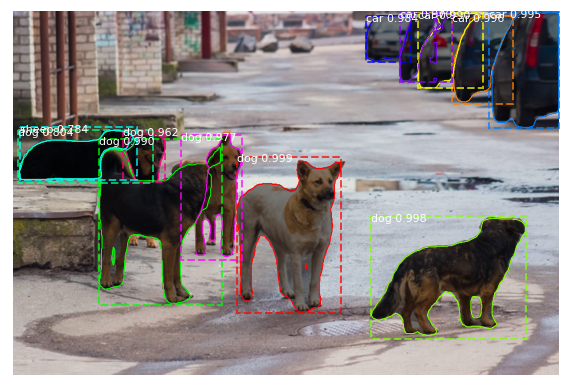

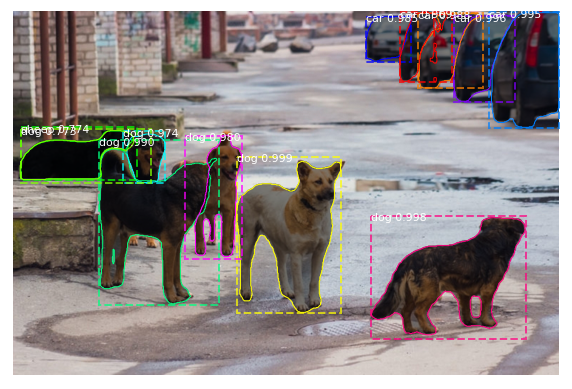

In [0]:
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=False, pretrained_backbone=False)
model.backbone = resnet50_fpn_backbone()
model.roi_heads.box_head = TwoMLPHead_quantized(12544, 1024)
model.load_state_dict(orig_model.state_dict())

_replace_relu(model.backbone)
_replace_relu(model.roi_heads.box_head)
#torch.backends.quantized.engine = 'fbgemm'
model.eval()
model.backbone.qconfig = torch.quantization.get_default_qconfig('fbgemm')
model.backbone.fuse_model()
model.roi_heads.box_head.qconfig = torch.quantization.get_default_qconfig('fbgemm')
model.roi_heads.box_head.fuse_model()
torch.quantization.prepare(model, inplace=True)
calibrate(model, data_loader, num=5)
torch.quantization.convert(model, inplace=True)
torch.jit.save(torch.jit.script(model), os.path.join(path, 'maskrcnn_quant_back_head_fbgemm.pth'))
model = torch.jit.load(os.path.join(path, 'maskrcnn_quant_back_head_fbgemm.pth'))
compare_two_models(orig_model, model)

[torch.Size([3, 500, 333]), torch.Size([3, 480, 640])]
[torch.Size([3, 427, 640]), torch.Size([3, 480, 640])]
[torch.Size([3, 480, 640]), torch.Size([3, 480, 640])]
[torch.Size([3, 640, 384]), torch.Size([3, 440, 640])]
[torch.Size([3, 480, 640]), torch.Size([3, 366, 640])]


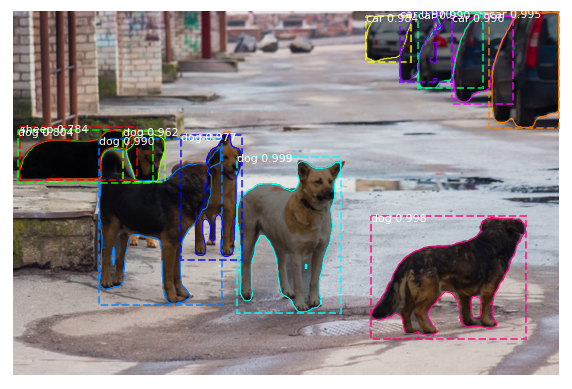

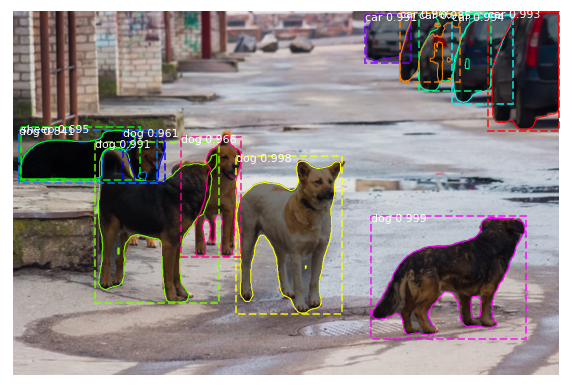

In [0]:
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=False, pretrained_backbone=False)
model.backbone = resnet50_fpn_backbone()
model.roi_heads.box_head = TwoMLPHead_quantized(12544, 1024)
model.load_state_dict(orig_model.state_dict())

_replace_relu(model.backbone)
_replace_relu(model.roi_heads.box_head)
#torch.backends.quantized.engine = 'qnnpack'
model.eval()
model.backbone.qconfig = torch.quantization.get_default_qconfig('qnnpack')
model.backbone.fuse_model()
model.roi_heads.box_head.qconfig = torch.quantization.get_default_qconfig('qnnpack')
model.roi_heads.box_head.fuse_model()
torch.quantization.prepare(model, inplace=True)
calibrate(model, data_loader, num=5)
torch.quantization.convert(model, inplace=True)
torch.jit.save(torch.jit.script(model), os.path.join(path, 'maskrcnn_quant_back_head_qnnpack.pth'))
model = torch.jit.load(os.path.join(path, 'maskrcnn_quant_back_head_qnnpack.pth'))
compare_two_models(orig_model, model)

In [0]:
torch._C._jit_set_profiling_mode(True)
torch.jit.optimized_execution(True)


##Checking

In [0]:
torch.backends.quantized.engine = 'fbgemm'
%memit model = torch.jit.load(os.path.join(path, 'maskrcnn_quant_back_head_fbgemm.pth'))
model.eval()
with torch.jit.optimized_execution(False), torch.no_grad():
    %memit a = model([get_image('https://farm4.staticflickr.com/3091/5853549513_cc819afa5e_z.jpg')])

peak memory: 372.42 MiB, increment: 108.56 MiB
peak memory: 1083.36 MiB, increment: 710.89 MiB


In [0]:
%memit orig_model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
orig_model.eval()
with torch.no_grad():
    %memit a = orig_model([get_image('https://farm4.staticflickr.com/3091/5853549513_cc819afa5e_z.jpg')])

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth



peak memory: 610.41 MiB, increment: 346.30 MiB
peak memory: 2396.62 MiB, increment: 1786.21 MiB


In [0]:
torch.backends.quantized.engine = 'fbgemm'
%memit model = torch.jit.load(os.path.join(path, 'maskrcnn_quant_back_head_fbgemm.pth'))
model.transform.max_size = 800
model.transform.min_size = (640,)
model.eval()
with torch.jit.optimized_execution(False), torch.no_grad():
    %memit a = model([get_image('https://farm4.staticflickr.com/3091/5853549513_cc819afa5e_z.jpg')])


peak memory: 369.45 MiB, increment: 104.80 MiB
peak memory: 804.73 MiB, increment: 435.25 MiB


In [0]:
orig_model.eval()
model.eval()
with torch.jit.optimized_execution(False), torch.no_grad():
    x = [get_image('https://farm4.staticflickr.com/3091/5853549513_cc819afa5e_z.jpg')]
    %timeit model(x)
    %timeit orig_model(x)    


1 loop, best of 3: 4.69 s per loop
1 loop, best of 3: 6.08 s per loop


In [0]:
!pip install yappi

     |████████████████████████████████| 51kB 1.7MB/s 
  Created wheel for yappi: filename=yappi-1.2.3-cp36-cp36m-linux_x86_64.whl size=79020 sha256=c903263fd149be6a7f501e23d252d3d12ee2d5caab2b24d036746e59329c56e5
  Stored in directory: /root/.cache/pip/wheels/d6/9e/a7/e0cc70f8685b52eedc76fa813a4b235047f24688e050aecd47
Successfully built yappi


In [0]:
import yappi, os
yappi.set_clock_type("wall")
x = [get_image('https://farm4.staticflickr.com/3091/5853549513_cc819afa5e_z.jpg')]

def test_model(model, x=[torch.randn((3,640,480),
                     dtype=torch.float32,
                     device=torch.device('cpu'))], num=10):
    model.eval()
    yappi.start()
    with torch.jit.optimized_execution(False), torch.no_grad():
        model(x)
    yappi.stop()
    stats = yappi.get_func_stats()#.sort('ttot')
    yappi.clear_stats()
    print("{:>40}\t{:<4}\t{}".format('Function', 'Calls', 'Total Time, sec'))
    for i, stat in enumerate(stats):
        print("{:>40}\t{:<4}\t{:0.3f}".format(stat.name, stat.ncall, stat.ttot))
        if i > num: break    
    return


In [0]:
test_model(orig_model, x=x)

                                Function	Calls	Total Time, sec
                       MaskRCNN.__call__	234 	6.159
                        MaskRCNN.forward	1   	6.156
                          Conv2d.forward	81  	3.787
                   Conv2d.conv2d_forward	81  	3.786
                 BackboneWithFPN.forward	1   	3.095
                      Sequential.forward	10  	2.618
                        RoIHeads.forward	1   	2.078
         IntermediateLayerGetter.forward	1   	2.045
                      Bottleneck.forward	16  	1.811
           FeaturePyramidNetwork.forward	1   	1.045
              MultiScaleRoIAlign.forward	2   	1.025
                               roi_align	8   	1.006


In [0]:
model = torch.jit.load(os.path.join(path, 'maskrcnn_quant_back_head_fbgemm.pth'))
#torch.jit.optimized_execution(False)
test_model(model, x=x)

                                Function	Calls	Total Time, sec
          RecursiveScriptModule.__call__	1   	4.699
                  TMonitor.get_instances	2   	0.000
                            WeakSet.copy	2   	0.000
                        WeakSet.__init__	2   	0.000
                          WeakSet.update	2   	0.000
                        WeakSet.__iter__	12  	0.000
                        no_grad.__exit__	1   	0.000
                              <listcomp>	2   	0.000
                             WeakSet.add	4   	0.000
          TqdmDefaultWriteLock.__enter__	1   	0.000
       _GeneratorContextManager.__exit__	1   	0.000
                     optimized_execution	2   	0.000


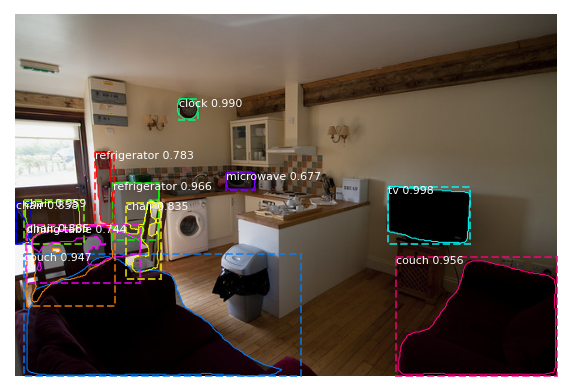

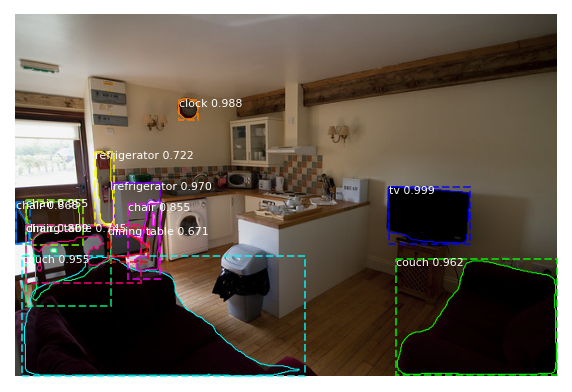

In [9]:
compare_two_models(orig_model, model, 'https://farm4.staticflickr.com/3091/5853549513_cc819afa5e_z.jpg')

In [0]:
qconfig = torch.quantization.get_default_qconfig('fbgemm')
print(qconfig)

QConfig(activation=functools.partial(<class 'torch.quantization.observer.HistogramObserver'>, reduce_range=True), weight=functools.partial(<class 'torch.quantization.observer.PerChannelMinMaxObserver'>, dtype=torch.qint8, qscheme=torch.per_channel_symmetric))
